In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import glob
from PIL import Image
import random
import numpy as np
import torchvision
from tqdm import tqdm
import os
from torch.nn import init
import cv2
import h5py
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# UNet Model

In [2]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = out_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=3),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Softmax(dim = 1)
                    )
            return  block
        
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        
        # Encode
        self.conv_encode1 = self.contracting_block(in_channels = in_channel, out_channels = 64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)
        
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 256, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1, stride = 1)
                            )
        
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2])
            upsampled = F.pad(upsampled, (int((c/2)), int((c/2)), int((c/2)), int((c/2))))
            c = bypass.shape[2] - upsampled.shape[2]
            upsampled = F.pad(upsampled, (c, 0, c, 0))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        
        return  final_layer

# UNet++ Model

In [3]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

### compute model params
def count_param(model):
    param_count = 0
    for param in model.parameters():
        param_count += param.view(-1).size()[0]
    return param_count

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size+(n_concat-2)*out_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, padding=0)
        else:
            self.up = nn.Sequential(
                 nn.UpsamplingBilinear2d(scale_factor=2),
                 nn.Conv2d(in_size, out_size, 1))
           
        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, high_feature, *low_feature):
        outputs0 = self.up(high_feature)
        for feature in low_feature:
            outputs0 = torch.cat([outputs0, feature], 1)
        return self.conv(outputs0)
    
class UNet_Nested(nn.Module):

    def __init__(self, in_channels=1, n_classes=2, feature_scale=2, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_Nested, self).__init__()
        self.in_channels = in_channels
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat01 = unetUp(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp(filters[2], filters[1], self.is_deconv, 4)
        
        self.up_concat04 = unetUp(filters[1], filters[0], self.is_deconv, 5)
        
        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)
        self.softmax = torch.nn.Softmax(dim = 1)
        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)       # 16*512*512
        maxpool0 = self.maxpool(X_00)    # 16*256*256
        X_10= self.conv10(maxpool0)      # 32*256*256
        maxpool1 = self.maxpool(X_10)    # 32*128*128
        X_20 = self.conv20(maxpool1)     # 64*128*128
        maxpool2 = self.maxpool(X_20)    # 64*64*64
        X_30 = self.conv30(maxpool2)     # 128*64*64
        maxpool3 = self.maxpool(X_30)    # 128*32*32
        X_40 = self.conv40(maxpool3)     # 256*32*32
        # column : 1
        X_01 = self.up_concat01(X_10,X_00)
        X_11 = self.up_concat11(X_20,X_10)
        X_21 = self.up_concat21(X_30,X_20)
        X_31 = self.up_concat31(X_40,X_30)
        # column : 2
        X_02 = self.up_concat02(X_11,X_00,X_01)
        X_12 = self.up_concat12(X_21,X_10,X_11)
        X_22 = self.up_concat22(X_31,X_20,X_21)
        # column : 3
        X_03 = self.up_concat03(X_12,X_00,X_01,X_02)
        X_13 = self.up_concat13(X_22,X_10,X_11,X_12)
        # column : 4
        X_04 = self.up_concat04(X_13,X_00,X_01,X_02,X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1+final_2+final_3+final_4)/4
#         final = self.softmax(final)

        if self.is_ds:
            return final
        else:
            return final_4

# Loading Dataset

In [4]:
# files = glob.glob('cells/stage1_train/*/images/*')

# X = []
# y = []
# c = 0

# for i in files:
#     c += 1
#     print(c)
#     img = np.array(cv2.resize((cv2.imread(i, cv2.COLOR_BGR2RGB)), (256, 256), interpolation = cv2.INTER_NEAREST))
#     masks = glob.glob('cells/stage1_train/' + i.split('/')[2] + '/masks/*')
#     m = np.zeros((img.shape[0], img.shape[1]))
#     for j in masks:
#         m += cv2.resize(np.array(cv2.imread(j, cv2.COLOR_BGR2RGB)), (256, 256), interpolation = cv2.INTER_NEAREST)
        
#     m = np.where(m == 255, 1, m) 
#     X.append(img)
#     y.append(m)

In [5]:
# X = np.array(X)
# y = np.array(y)

# n = X.shape[0]
# sample = random.sample(range(0, n), n)
# sample = np.array(sample)

In [6]:
# np.save('sample-cell', sample)

In [7]:
sample = np.load('sample-cell.npy')
train = sample[:500]
val = sample[500:550]
test = sample[550:]

In [8]:
# np.save('X_2', X)
# np.save('y_2', y)

In [9]:
X = np.load('X_2.npy')
y = np.load('y_2.npy')

# Implementing the model

In [10]:
unet_plus = UNet_Nested(in_channels = 3, n_classes = 2)
optimizer = torch.optim.Adam(unet_plus.parameters(), lr = 1e-3)
unet_plus = nn.DataParallel(unet_plus)
unet_plus.to("cuda")

DataParallel(
  (module): UNet_Nested(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv00): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv10): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [11]:
# unet = UNet(in_channel = 3, out_channel = 2)
# optimizer = torch.optim.Adam(unet.parameters(), lr = 1e-3)
# unet = nn.DataParallel(unet)
# unet.to("cuda")

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets.float(), reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [13]:
epochs = 60
batch_size = 16
total_batches = train.shape[0] // batch_size

criterion = DiceBCELoss()

history = []
dev_history = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    total_dev_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad() 
        
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, X[0].shape[0], X[0].shape[1], X[0].shape[2]))
      label = np.zeros((batch_size, y[0].shape[0], y[0].shape[1]))
      for b in range(batch_size):
            inp[b] = X[train[c]]
            label[b] = y[train[c]]
            c += 1
    
            
      inp = (torch.from_numpy(inp))
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
            
      # Generating outputs  
      outputs = unet_plus(inp)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
      label = F.one_hot(label, num_classes = 2).permute(0, 3, 1, 2)

      # Calculating loss
      loss = criterion(outputs, label)
      loss.backward()
      total_loss += float(loss.item())
      optimizer.step()
        
    total_loss /= total_batches
    history.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, X[0].shape[0], X[0].shape[1], X[0].shape[2]))
        dev_label = np.zeros((batch_size, y[0].shape[0], y[0].shape[1]))
        for b in range(batch_size):
            dev_input[b] = X[val[c1]]
            dev_label[b] = y[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_plus(dev_input)
        
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        dev_label = F.one_hot(dev_label, num_classes = 2).permute(0, 3, 1, 2)
        
        dev_loss = criterion(dev_output, dev_label)
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= total_batches
    dev_history.append(total_dev_loss * 10)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss) + ', Val Loss : ' + str(total_dev_loss * 10))

Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 1 / 60, Loss : 0.42280272658794155, Val Loss : 0.17589991131136493


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 2 / 60, Loss : 0.1788933630431852, Val Loss : 0.14386509695360739


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 3 / 60, Loss : 0.14561029499576938, Val Loss : 0.13182064458247153


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 4 / 60, Loss : 0.13091395290628557, Val Loss : 0.1317632871289407


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 5 / 60, Loss : 0.12402664389341109, Val Loss : 0.12198047051506658


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 6 / 60, Loss : 0.11855781150441017, Val Loss : 0.09755187217266328


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 7 / 60, Loss : 0.12108035265438018, Val Loss : 0.12004192437856429


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 8 / 60, Loss : 0.11481822618553715, Val Loss : 0.08775991658049245


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 9 / 60, Loss : 0.10767506543667085, Val Loss : 0.08525949091680587


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 10 / 60, Loss : 0.10332425323224836, Val Loss : 0.08433826988743197


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 11 / 60, Loss : 0.10031289703422977, Val Loss : 0.08655849483705336


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 12 / 60, Loss : 0.0997853429327088, Val Loss : 0.09270274831402686


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 13 / 60, Loss : 0.09695317812504307, Val Loss : 0.08393691552262153


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 14 / 60, Loss : 0.09632055473423773, Val Loss : 0.08064220749562787


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 15 / 60, Loss : 0.09432784503986759, Val Loss : 0.082451309407911


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 16 / 60, Loss : 0.09337968871958795, Val Loss : 0.08298513629744131


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 17 / 60, Loss : 0.09277205673917648, Val Loss : 0.08145653432415377


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 18 / 60, Loss : 0.09391066444016272, Val Loss : 0.08272609643397792


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 19 / 60, Loss : 0.09139163083126468, Val Loss : 0.07754221077888242


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 20 / 60, Loss : 0.09120127222230358, Val Loss : 0.07674537238574797


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 21 / 60, Loss : 0.08833716317049918, Val Loss : 0.07813927867720205


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 22 / 60, Loss : 0.0874952063445122, Val Loss : 0.078743280422303


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 23 / 60, Loss : 0.08580703336384989, Val Loss : 0.07453870989622609


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 24 / 60, Loss : 0.08715968434849093, Val Loss : 0.08115934628632761


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 25 / 60, Loss : 0.08473511580978671, Val Loss : 0.07357033991044568


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 26 / 60, Loss : 0.08220224659289083, Val Loss : 0.07341166177103596


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 27 / 60, Loss : 0.08349698529608789, Val Loss : 0.07351468166997356


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 28 / 60, Loss : 0.08107568287561016, Val Loss : 0.07234678874092718


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 29 / 60, Loss : 0.08066945895552635, Val Loss : 0.0704973743807885


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 30 / 60, Loss : 0.08314892096865562, Val Loss : 0.07939039338980951


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 31 / 60, Loss : 0.09503897471774009, Val Loss : 0.07637001453868805


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 32 / 60, Loss : 0.08569157375924048, Val Loss : 0.07404083566319558


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 33 / 60, Loss : 0.08220860794667274, Val Loss : 0.07372161794093347


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 34 / 60, Loss : 0.08478925581420621, Val Loss : 0.07213112207189683


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 35 / 60, Loss : 0.08254035442106185, Val Loss : 0.07463292489128728


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 36 / 60, Loss : 0.08333981878334476, Val Loss : 0.07177600576992958


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 37 / 60, Loss : 0.07994929496799746, Val Loss : 0.07446324272501853


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 38 / 60, Loss : 0.08122400038184659, Val Loss : 0.07195132514161448


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 39 / 60, Loss : 0.07862933076197101, Val Loss : 0.07357780250810808


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 40 / 60, Loss : 0.07745157566762739, Val Loss : 0.07500081052703242


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 41 / 60, Loss : 0.07766619577042518, Val Loss : 0.0697359154301305


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 42 / 60, Loss : 0.07558959470160546, Val Loss : 0.07008663108271937


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 43 / 60, Loss : 0.07544284542241404, Val Loss : 0.06892298618631978


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 44 / 60, Loss : 0.07469802710317797, Val Loss : 0.07636156173483018


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 45 / 60, Loss : 0.07439190930416507, Val Loss : 0.07572047412395477


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 46 / 60, Loss : 0.07397190890004558, Val Loss : 0.08026109587761664


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 47 / 60, Loss : 0.0736530430374607, Val Loss : 0.07781061914659315


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 48 / 60, Loss : 0.07155636914314763, Val Loss : 0.08367117854856676


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 49 / 60, Loss : 0.07440440116390105, Val Loss : 0.08102402331367616


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 50 / 60, Loss : 0.07782990461395632, Val Loss : 0.07014665632478653


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 51 / 60, Loss : 0.07626517273245319, Val Loss : 0.0741186353468126


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 52 / 60, Loss : 0.07579019016796543, Val Loss : 0.07029182247577175


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 53 / 60, Loss : 0.07227848506262226, Val Loss : 0.08018392468652419


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 54 / 60, Loss : 0.07065111002133738, Val Loss : 0.07669171859179774


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 55 / 60, Loss : 0.07179860914907148, Val Loss : 0.07636387261652178


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 56 / 60, Loss : 0.06912634870217692, Val Loss : 0.0757250742566201


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 57 / 60, Loss : 0.06825391611745281, Val Loss : 0.0718832015991211


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 58 / 60, Loss : 0.06629131662268792, Val Loss : 0.0713077944613272


Epoch is running ::   0%|          | 0/31 [00:00<?, ?it/s]

Epoch : 59 / 60, Loss : 0.06563807711485893, Val Loss : 0.07590602482518842


Epoch is running :: 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]


Epoch : 60 / 60, Loss : 0.06337650144292463, Val Loss : 0.0766507920718962


In [15]:
# torch.save(unet_plus.module.state_dict(), 'unet_plus-cell')

In [11]:
# Loading the UNet++ model
device = torch.device("cuda")
unet_plus = UNet_Nested(in_channels = 3, n_classes = 2)
unet_plus.load_state_dict(torch.load('unet_plus-cell'))
unet_plus.to(device)

UNet_Nested(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
# Loading the UNet model
device = torch.device("cuda")
unet = UNet(in_channel = 3, out_channel = 2)
unet.load_state_dict(torch.load('unet-cell'))
unet.to(device)

UNet(
  (conv_encode1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), st

# Visualizing Results

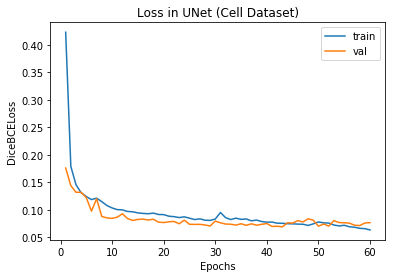

In [16]:
epoch = np.arange(1, 61)
plt.plot(epoch, history)
plt.plot(epoch, dev_history)
plt.xlabel('Epochs')
plt.ylabel('DiceBCELoss')
plt.title('Loss in UNet (Cell Dataset)')
plt.legend(['train', 'val'])
plt.show()

# UNet and UNet++ Result

In [35]:
k = 49
a = test[k]

inp = torch.from_numpy(X[a])
inp = torch.unsqueeze(inp, 0).to(device).permute(0, 3, 1, 2)

outputs_plus = unet_plus(inp.float())
outputs_plus = torch.argmax(outputs_plus, dim = 1).cpu()
outputs_plus = torch.squeeze(outputs_plus, 0)
output_plus = F.one_hot(outputs_plus, num_classes = 2)

outputs = unet(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 2)

label = y[a]
out = np.zeros((256, 256, 2))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

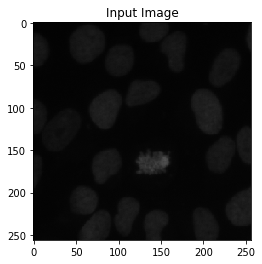

In [36]:
plt.imshow(X[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Cells (Ground Truth)')

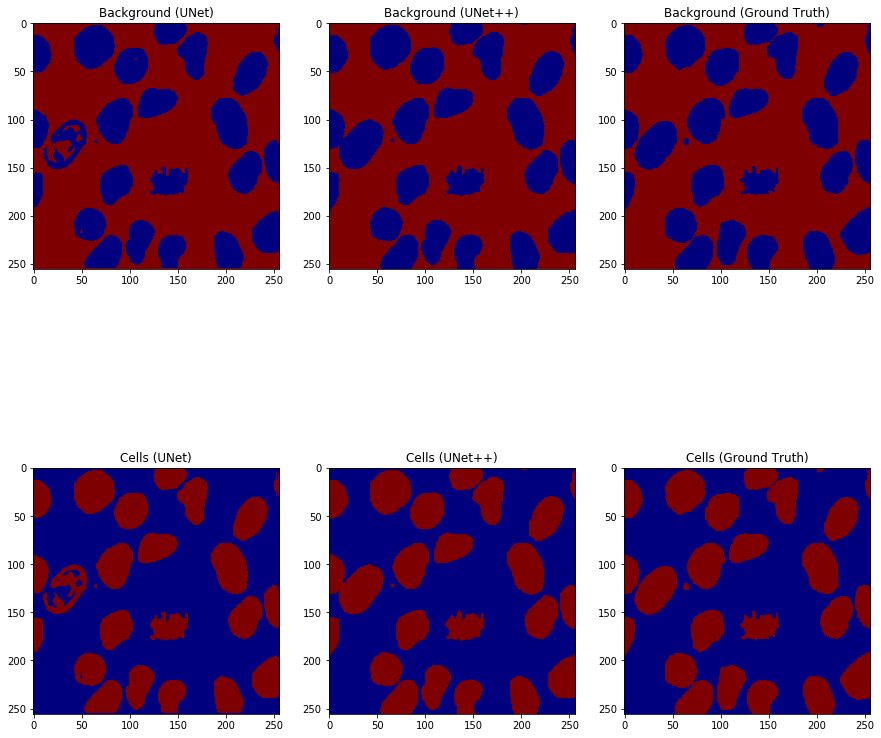

In [37]:
h, m = cv2.split(np.array(output))
h_, m_ = cv2.split(np.array(output_plus))
h1, m1 = cv2.split(np.array(out))

f, ax = plt.subplots(2, 3, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Background (UNet)')
ax[0, 1].imshow(h_, cmap = 'jet')
ax[0, 1].set_title('Background (UNet++)')
ax[0, 2].imshow(h1, cmap = 'jet')
ax[0, 2].set_title('Background (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Cells (UNet)')
ax[1, 1].imshow(m_, cmap = 'jet')
ax[1, 1].set_title('Cells (UNet++)')
ax[1, 2].imshow(m1, cmap = 'jet')
ax[1, 2].set_title('Cells (Ground Truth)')

# Metric Evaluation on Test Set

In [83]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

def accuracy(outputs, target):
    outputs = F.one_hot(torch.argmax(outputs, dim = 2), num_classes = 2)
    a = np.count_nonzero(np.equal(outputs.detach().cpu(), target))
    b = outputs.shape[0] * outputs.shape[1] * outputs.shape[2]
    return (a / b) * 100

In [88]:
total_iou_score = 0
total_accuracy = 0
total_loss = 0
c = 0

for i in range(test.shape[0]):
    c += 1
    print(c)
    a = test[i]
    inp = torch.from_numpy(X[a])
    inp = torch.unsqueeze(inp, 0).to(device).permute(0, 3, 1, 2)
    outputs = unet(inp.float())
    outputs = torch.squeeze(outputs, 0).permute(1, 2, 0)

    label = y[a]
    out = np.zeros((label.shape[0], label.shape[1], 2))
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i][j] == 0:
          out[i][j][0] = 1
        elif label[i][j] == 1:
          out[i][j][1] = 1
        if label[i][j] == 2:
          out[i][j][2] = 1
        if label[i][j] == 3:
          out[i][j][3] = 1

    total_iou_score += iou_score(outputs, out)
    total_accuracy += accuracy(outputs, out)
    total_loss += criterion(outputs.to(device), torch.from_numpy(out).to(device)).item()
    
total_iou_score /= 613
total_accuracy /= 613
total_loss /= 613

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [99]:
total_iou_score_plus = 0
total_accuracy_plus = 0
total_loss_plus = 0
c = 0

for i in range(test.shape[0]):
    c += 1
    print(c)
    a = test[i]
    inp = torch.from_numpy(X[a])
    inp = torch.unsqueeze(inp, 0).to(device).permute(0, 3, 1, 2)
    outputs = unet_plus(inp.float())
    outputs = torch.squeeze(outputs, 0).permute(1, 2, 0)

    label = y[a]
    out = np.zeros((label.shape[0], label.shape[1], 2))
    for i in range(label.shape[0]):
      for j in range(label.shape[1]):
        if label[i][j] == 0:
          out[i][j][0] = 1
        elif label[i][j] == 1:
          out[i][j][1] = 1
        if label[i][j] == 2:
          out[i][j][2] = 1
        if label[i][j] == 3:
          out[i][j][3] = 1

    total_iou_score_plus += iou_score(outputs, out)
    total_accuracy_plus += accuracy(outputs, out)
    total_loss_plus += criterion(outputs.to(device), torch.from_numpy(out).to(device)).item()
    
total_iou_score_plus /= 613
total_accuracy_plus /= 613
total_loss_plus /= 613

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [102]:
print('IoU score : ' + str(total_iou_score) + ', Accuracy : ' + str(total_accuracy) + ', BCE Dice Loss : ' + str(total_loss))

IoU score : 0.09813962007835818, Accuracy : 18.852116894371942, BCE Dice Loss : 0.1743289794562974


In [103]:
print('IoU score : ' + str(total_iou_score_plus) + ', Accuracy : ' + str(total_accuracy_plus) + ', BCE Dice Loss : ' + str(total_loss_plus))

IoU score : 0.18627788461113173, Accuracy : 19.071995298002907, BCE Dice Loss : 0.023662850329556066
